In [1]:
%matplotlib inline
import datetime
import backtrader as bt

In [2]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [3]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy, maperiod=10)

data = bt.feeds.YahooFinanceData(
    dataname='ORCL',
    adjclose=True,
    fromdate=datetime.datetime(2000, 1, 1),
    todate=datetime.datetime(2010, 1, 1))

cerebro.adddata(data)

cerebro.broker.setcash(100000.0)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.broker.setcommission(commission=0.001)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2000-02-18, Close, 26.57
2000-02-22, Close, 26.91
2000-02-23, Close, 28.61
2000-02-23, BUY CREATE, 28.61
2000-02-24, BUY EXECUTED, Price: 31.59, Cost: 315.90, Comm 0.32
2000-02-24, Close, 28.10
2000-02-25, Close, 32.04
2000-02-28, Close, 31.13
2000-02-29, Close, 33.69
2000-03-01, Close, 32.44
2000-03-02, Close, 31.08
2000-03-03, Close, 34.03
2000-03-06, Close, 34.37
2000-03-07, Close, 34.00
2000-03-08, Close, 37.71
2000-03-09, Close, 38.11
2000-03-10, Close, 37.03
2000-03-13, Close, 35.73
2000-03-14, Close, 34.93
2000-03-14, SELL CREATE, 34.93
2000-03-15, SELL EXECUTED, Price: 42.00, Cost: 315.90, Comm 0.42
2000-03-15, OPERATION PROFIT, GROSS 104.10, NET 103.36
2000-03-15, Close, 35.67
2000-03-15, BUY CREATE, 35.67
2000-03-16, BUY EXECUTED, Price: 40.34, Cost: 403.40, Comm 0.40
2000-03-16, Close, 37.17
2000-03-17, Close, 36.21
2000-03-20, Close, 35.44
2000-03-20, SELL CREATE, 35.44
2000-03-21, SELL EXECUTED, Price: 38.94, Cost: 403.40, Comm 0.39
2000

2001-01-23, OPERATION PROFIT, GROSS 14.40, NET 13.78
2001-01-23, Close, 28.57
2001-01-24, Close, 27.28
2001-01-25, Close, 27.16
2001-01-26, Close, 27.56
2001-01-29, Close, 27.62
2001-01-30, Close, 27.50
2001-01-31, Close, 26.43
2001-02-01, Close, 27.28
2001-02-02, Close, 25.18
2001-02-05, Close, 24.95
2001-02-06, Close, 25.07
2001-02-07, Close, 25.12
2001-02-08, Close, 24.61
2001-02-09, Close, 21.38
2001-02-12, Close, 20.87
2001-02-13, Close, 20.47
2001-02-14, Close, 22.68
2001-02-15, Close, 23.14
2001-02-16, Close, 21.78
2001-02-20, Close, 20.98
2001-02-21, Close, 20.87
2001-02-22, Close, 21.21
2001-02-23, Close, 19.96
2001-02-26, Close, 21.04
2001-02-27, Close, 19.68
2001-02-28, Close, 17.24
2001-03-01, Close, 19.39
2001-03-02, Close, 15.31
2001-03-05, Close, 15.43
2001-03-06, Close, 15.99
2001-03-07, Close, 16.90
2001-03-08, Close, 15.88
2001-03-09, Close, 14.86
2001-03-12, Close, 13.78
2001-03-13, Close, 15.37
2001-03-14, Close, 14.57
2001-03-15, Close, 13.33
2001-03-16, Close, 12.

2002-07-16, Close, 9.06
2002-07-17, Close, 9.50
2002-07-18, Close, 9.12
2002-07-19, Close, 8.82
2002-07-22, Close, 8.37
2002-07-22, SELL CREATE, 8.37
2002-07-23, SELL EXECUTED, Price: 9.36, Cost: 95.60, Comm 0.09
2002-07-23, OPERATION PROFIT, GROSS -2.00, NET -2.19
2002-07-23, Close, 7.98
2002-07-24, Close, 8.53
2002-07-25, Close, 8.18
2002-07-26, Close, 8.47
2002-07-29, Close, 8.67
2002-07-30, Close, 8.96
2002-07-30, BUY CREATE, 8.96
2002-07-31, BUY EXECUTED, Price: 9.72, Cost: 97.20, Comm 0.10
2002-07-31, Close, 9.08
2002-08-01, Close, 8.77
2002-08-02, Close, 8.54
2002-08-02, SELL CREATE, 8.54
2002-08-05, SELL EXECUTED, Price: 9.30, Cost: 97.20, Comm 0.09
2002-08-05, OPERATION PROFIT, GROSS -4.20, NET -4.39
2002-08-05, Close, 8.18
2002-08-06, Close, 8.47
2002-08-07, Close, 8.64
2002-08-07, BUY CREATE, 8.64
2002-08-08, BUY EXECUTED, Price: 9.49, Cost: 94.90, Comm 0.09
2002-08-08, Close, 9.08
2002-08-09, Close, 8.90
2002-08-12, Close, 8.83
2002-08-13, Close, 8.25
2002-08-13, SELL CREAT

2003-10-15, Close, 11.00
2003-10-15, SELL CREATE, 11.00
2003-10-16, SELL EXECUTED, Price: 12.10, Cost: 120.70, Comm 0.12
2003-10-16, OPERATION PROFIT, GROSS 0.30, NET 0.06
2003-10-16, Close, 10.86
2003-10-17, Close, 10.63
2003-10-20, Close, 10.81
2003-10-21, Close, 10.87
2003-10-22, Close, 10.63
2003-10-23, Close, 10.66
2003-10-24, Close, 10.64
2003-10-27, Close, 10.62
2003-10-28, Close, 10.87
2003-10-28, BUY CREATE, 10.87
2003-10-29, BUY EXECUTED, Price: 11.93, Cost: 119.30, Comm 0.12
2003-10-29, Close, 10.79
2003-10-30, Close, 11.06
2003-10-31, Close, 10.86
2003-11-03, Close, 11.06
2003-11-04, Close, 11.08
2003-11-05, Close, 11.21
2003-11-06, Close, 11.52
2003-11-07, Close, 11.31
2003-11-10, Close, 11.41
2003-11-11, Close, 11.38
2003-11-12, Close, 11.59
2003-11-13, Close, 11.41
2003-11-14, Close, 11.15
2003-11-14, SELL CREATE, 11.15
2003-11-17, SELL EXECUTED, Price: 12.24, Cost: 119.30, Comm 0.12
2003-11-17, OPERATION PROFIT, GROSS 3.10, NET 2.86
2003-11-17, Close, 10.97
2003-11-18, 

2004-08-12, OPERATION PROFIT, GROSS -3.00, NET -3.20
2004-08-12, Close, 8.98
2004-08-13, Close, 9.30
2004-08-16, Close, 9.30
2004-08-17, Close, 9.33
2004-08-18, Close, 9.54
2004-08-18, BUY CREATE, 9.54
2004-08-19, BUY EXECUTED, Price: 10.44, Cost: 104.40, Comm 0.10
2004-08-19, Close, 9.45
2004-08-20, Close, 9.35
2004-08-20, SELL CREATE, 9.35
2004-08-23, SELL EXECUTED, Price: 10.33, Cost: 104.40, Comm 0.10
2004-08-23, OPERATION PROFIT, GROSS -1.10, NET -1.31
2004-08-23, Close, 9.35
2004-08-23, BUY CREATE, 9.35
2004-08-24, BUY EXECUTED, Price: 10.33, Cost: 103.30, Comm 0.10
2004-08-24, Close, 9.37
2004-08-25, Close, 9.44
2004-08-26, Close, 9.28
2004-08-26, SELL CREATE, 9.28
2004-08-27, SELL EXECUTED, Price: 10.24, Cost: 103.30, Comm 0.10
2004-08-27, OPERATION PROFIT, GROSS -0.90, NET -1.11
2004-08-27, Close, 9.34
2004-08-30, Close, 9.17
2004-08-31, Close, 9.05
2004-09-01, Close, 9.12
2004-09-02, Close, 9.34
2004-09-02, BUY CREATE, 9.34
2004-09-03, BUY EXECUTED, Price: 10.20, Cost: 102.00

2005-11-10, OPERATION PROFIT, GROSS -0.70, NET -0.95
2005-11-10, Close, 11.52
2005-11-10, BUY CREATE, 11.52
2005-11-11, BUY EXECUTED, Price: 12.70, Cost: 127.00, Comm 0.13
2005-11-11, Close, 11.62
2005-11-14, Close, 11.63
2005-11-15, Close, 11.50
2005-11-16, Close, 11.33
2005-11-16, SELL CREATE, 11.33
2005-11-17, SELL EXECUTED, Price: 12.45, Cost: 127.00, Comm 0.12
2005-11-17, OPERATION PROFIT, GROSS -2.50, NET -2.75
2005-11-17, Close, 11.44
2005-11-18, Close, 11.45
2005-11-21, Close, 11.29
2005-11-22, Close, 11.24
2005-11-23, Close, 11.47
2005-11-23, BUY CREATE, 11.47
2005-11-25, BUY EXECUTED, Price: 12.67, Cost: 126.70, Comm 0.13
2005-11-25, Close, 11.44
2005-11-25, SELL CREATE, 11.44
2005-11-28, SELL EXECUTED, Price: 12.59, Cost: 126.70, Comm 0.13
2005-11-28, OPERATION PROFIT, GROSS -0.80, NET -1.05
2005-11-28, Close, 11.38
2005-11-29, Close, 11.55
2005-11-29, BUY CREATE, 11.55
2005-11-30, BUY EXECUTED, Price: 12.71, Cost: 127.10, Comm 0.13
2005-11-30, Close, 11.43
2005-12-01, Close

2007-03-20, BUY EXECUTED, Price: 17.25, Cost: 172.50, Comm 0.17
2007-03-20, Close, 15.92
2007-03-21, Close, 16.49
2007-03-22, Close, 16.78
2007-03-23, Close, 16.55
2007-03-26, Close, 16.69
2007-03-27, Close, 16.78
2007-03-28, Close, 16.49
2007-03-29, Close, 16.48
2007-03-30, Close, 16.45
2007-04-02, Close, 16.46
2007-04-02, SELL CREATE, 16.46
2007-04-03, SELL EXECUTED, Price: 18.23, Cost: 172.50, Comm 0.18
2007-04-03, OPERATION PROFIT, GROSS 9.80, NET 9.45
2007-04-03, Close, 16.66
2007-04-03, BUY CREATE, 16.66
2007-04-04, BUY EXECUTED, Price: 18.35, Cost: 183.50, Comm 0.18
2007-04-04, Close, 16.84
2007-04-05, Close, 16.94
2007-04-09, Close, 16.85
2007-04-10, Close, 17.10
2007-04-11, Close, 16.87
2007-04-12, Close, 16.97
2007-04-13, Close, 16.90
2007-04-16, Close, 17.15
2007-04-17, Close, 17.14
2007-04-18, Close, 16.99
2007-04-19, Close, 17.02
2007-04-20, Close, 17.24
2007-04-23, Close, 17.19
2007-04-24, Close, 17.08
2007-04-25, Close, 17.15
2007-04-26, Close, 17.19
2007-04-27, Close, 1

2008-06-25, BUY CREATE, 20.46
2008-06-26, BUY EXECUTED, Price: 21.68, Cost: 216.80, Comm 0.22
2008-06-26, Close, 19.44
2008-06-26, SELL CREATE, 19.44
2008-06-27, SELL EXECUTED, Price: 21.39, Cost: 216.80, Comm 0.21
2008-06-27, OPERATION PROFIT, GROSS -2.90, NET -3.33
2008-06-27, Close, 19.32
2008-06-30, Close, 19.05
2008-07-01, Close, 19.34
2008-07-02, Close, 18.89
2008-07-03, Close, 18.81
2008-07-07, Close, 19.14
2008-07-08, Close, 19.58
2008-07-08, BUY CREATE, 19.58
2008-07-09, BUY EXECUTED, Price: 21.48, Cost: 214.80, Comm 0.21
2008-07-09, Close, 19.15
2008-07-09, SELL CREATE, 19.15
2008-07-10, SELL EXECUTED, Price: 21.17, Cost: 214.80, Comm 0.21
2008-07-10, OPERATION PROFIT, GROSS -3.10, NET -3.53
2008-07-10, Close, 19.32
2008-07-10, BUY CREATE, 19.32
2008-07-11, BUY EXECUTED, Price: 21.07, Cost: 210.70, Comm 0.21
2008-07-11, Close, 19.02
2008-07-11, SELL CREATE, 19.02
2008-07-14, SELL EXECUTED, Price: 21.10, Cost: 210.70, Comm 0.21
2008-07-14, OPERATION PROFIT, GROSS 0.30, NET -0.

In [4]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Entire data start date: 2000-01-03
Entire data end date: 2009-12-31
Backtest months: 119


,Backtest
Annual return,-0.0%
Cumulative returns,-0.5%
Annual volatility,0.1%
Sharpe ratio,-0.32
Calmar ratio,-0.08
Stability,0.73
Max drawdown,-0.6%
Omega ratio,0.92
Sortino ratio,-0.45
Skew,-0.08


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.60,2000-03-15,2008-12-18,NaT,NaN
1,0.04,2000-02-23,2000-02-24,2000-02-25,3
2,0.03,2000-03-09,2000-03-14,2000-03-15,5
3,0.03,2000-02-29,2000-03-02,2000-03-03,4
4,0.01,2000-02-25,2000-02-28,2000-02-29,3


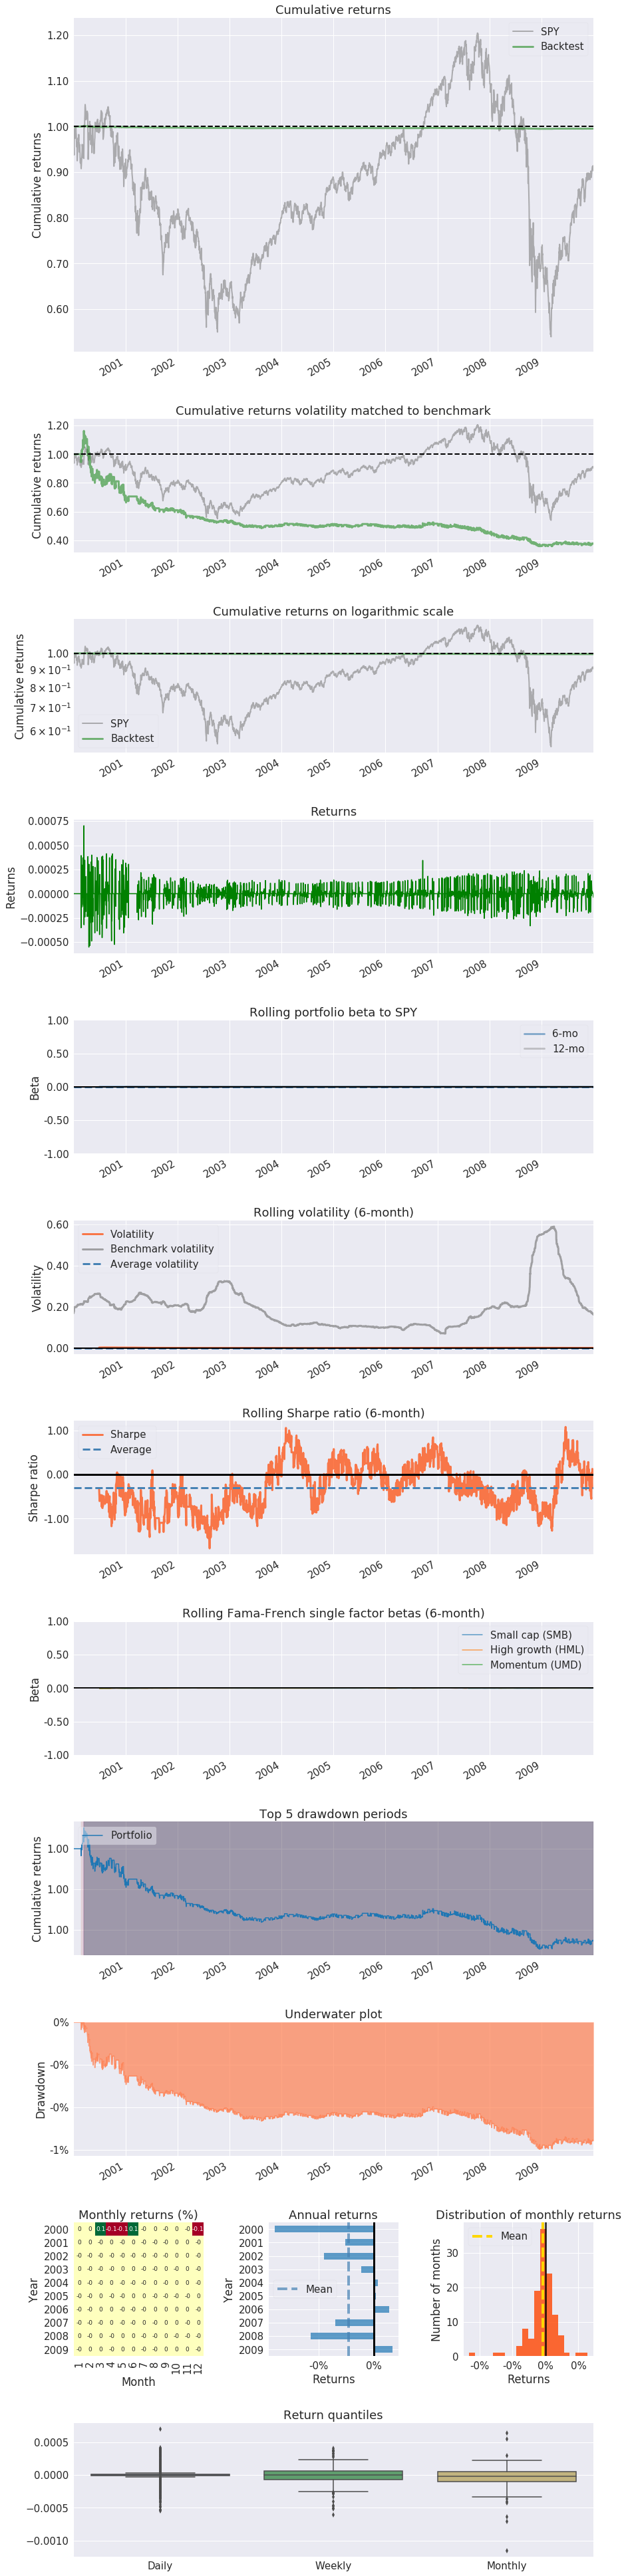

Stress Events,mean,min,max
Dotcom,-0.00%,-0.06%,0.07%
Lehmann,-0.00%,-0.03%,0.02%
9/11,0.00%,-0.02%,0.01%
US Housing,-0.00%,-0.02%,0.01%
Aug07,-0.00%,-0.02%,0.02%
Mar08,0.00%,-0.02%,0.02%
Sept08,-0.00%,-0.02%,0.02%
2009Q1,0.00%,-0.01%,0.02%
2009Q2,0.00%,-0.02%,0.02%
Low Volatility Bull Market,0.00%,-0.02%,0.03%


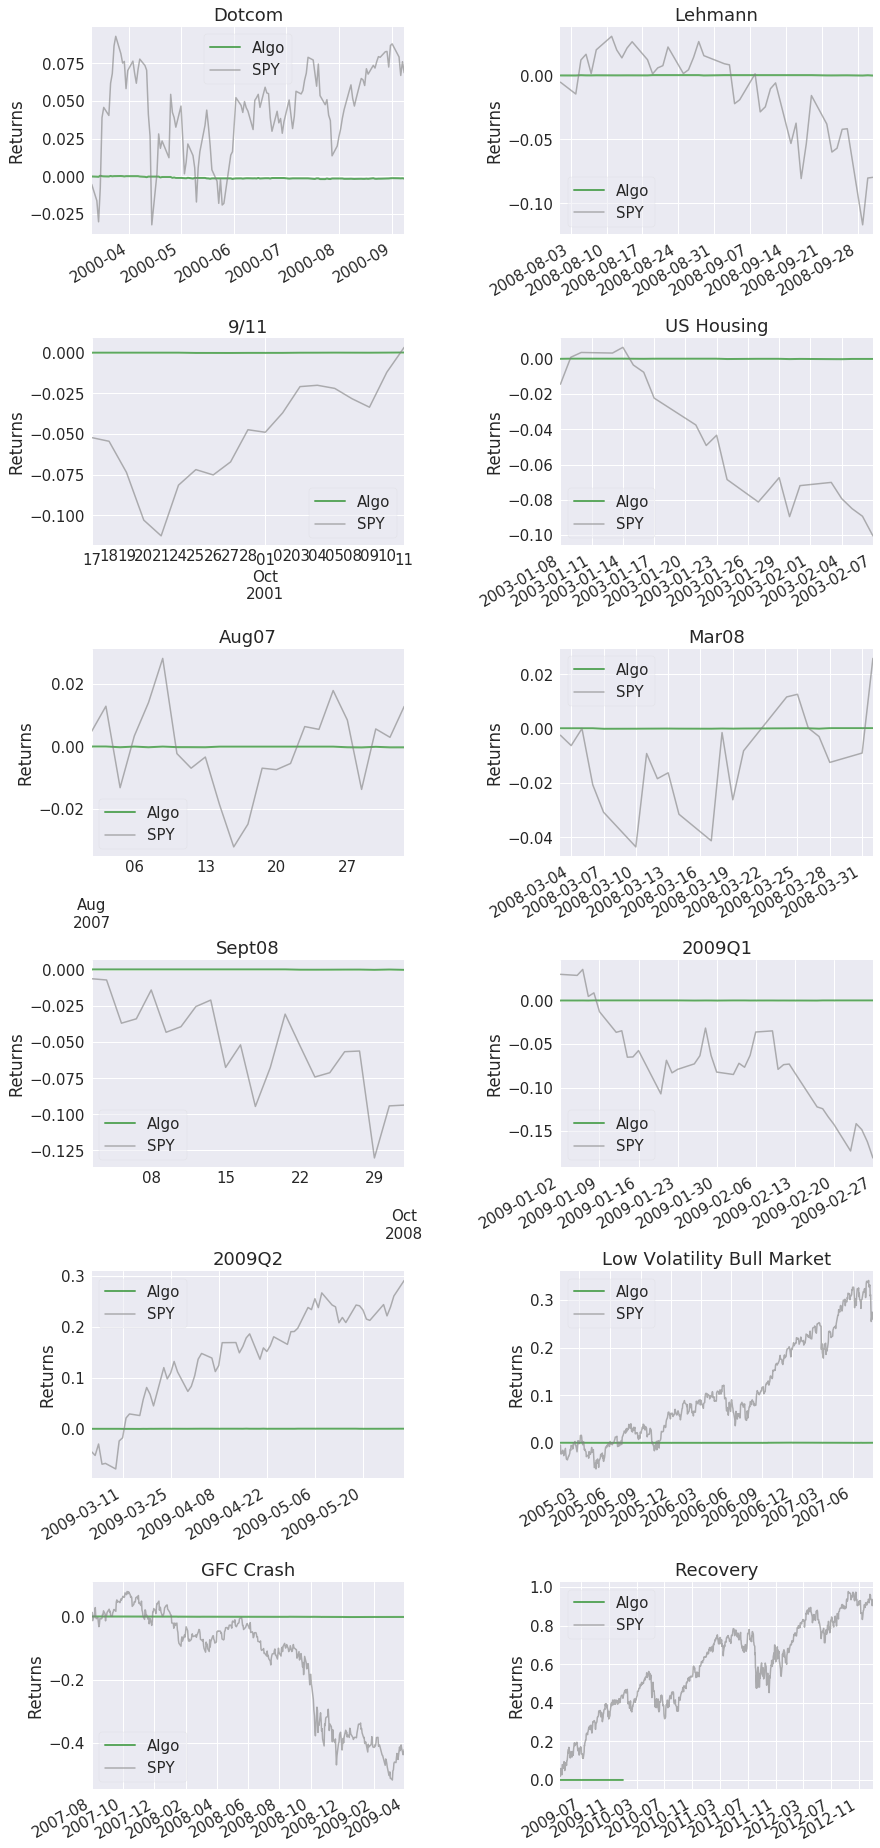

Top 10 long positions of all time,max
ORCL,0.42%


Top 10 short positions of all time,max


Top 10 positions of all time,max
ORCL,0.42%


All positions ever held,max
ORCL,0.42%


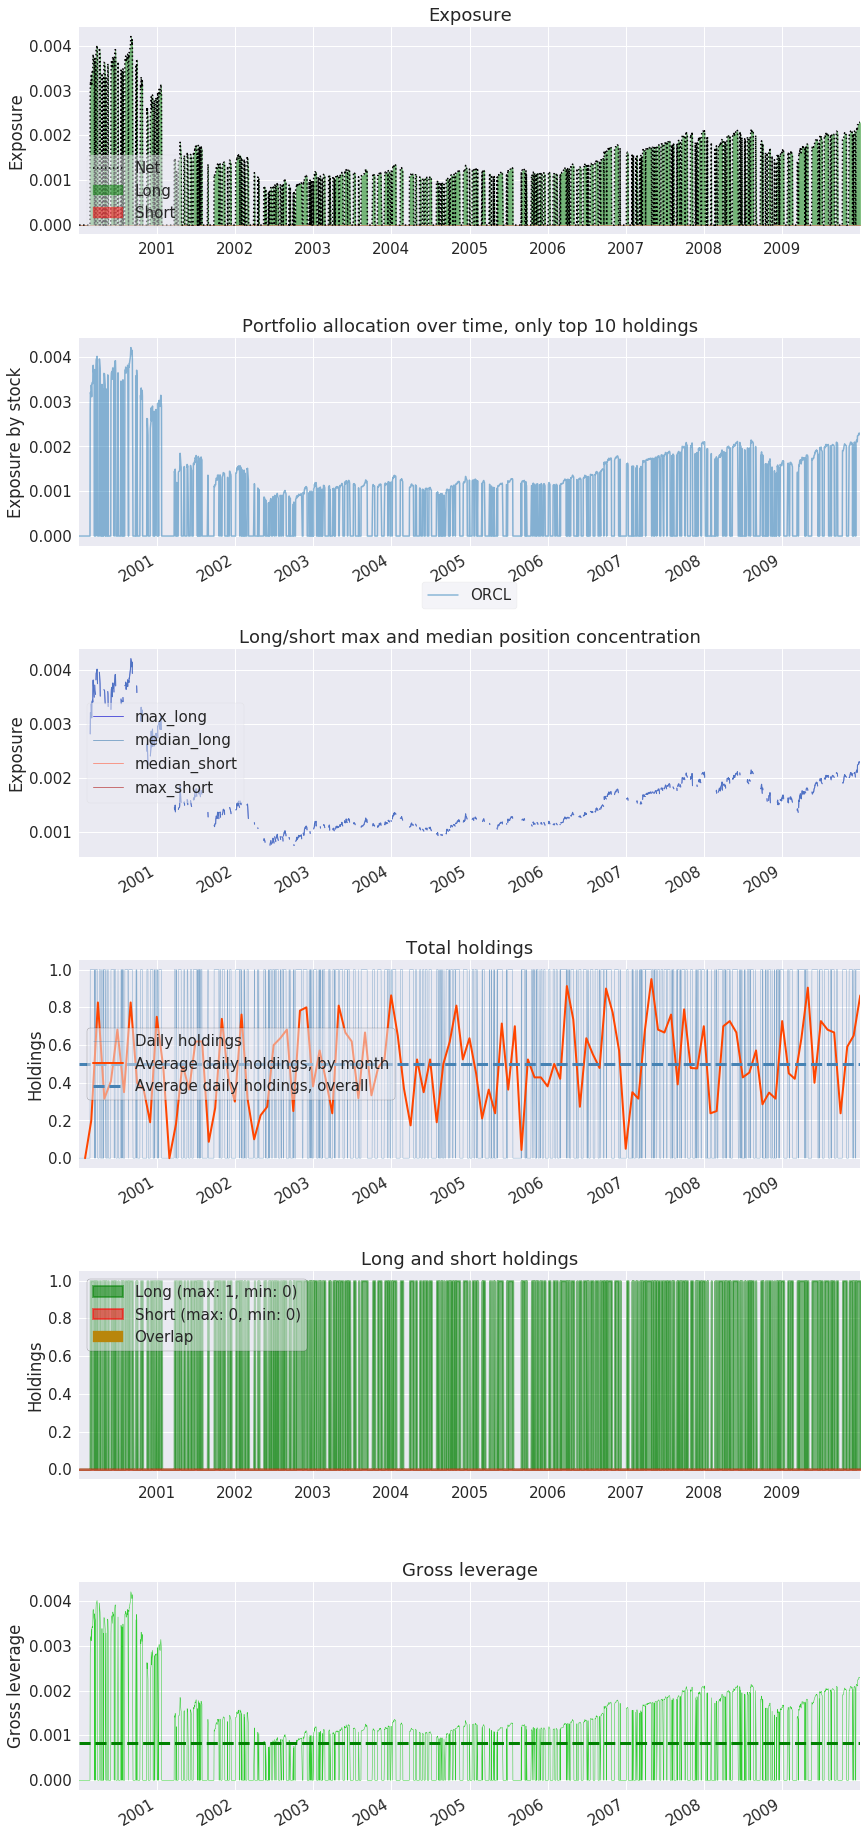

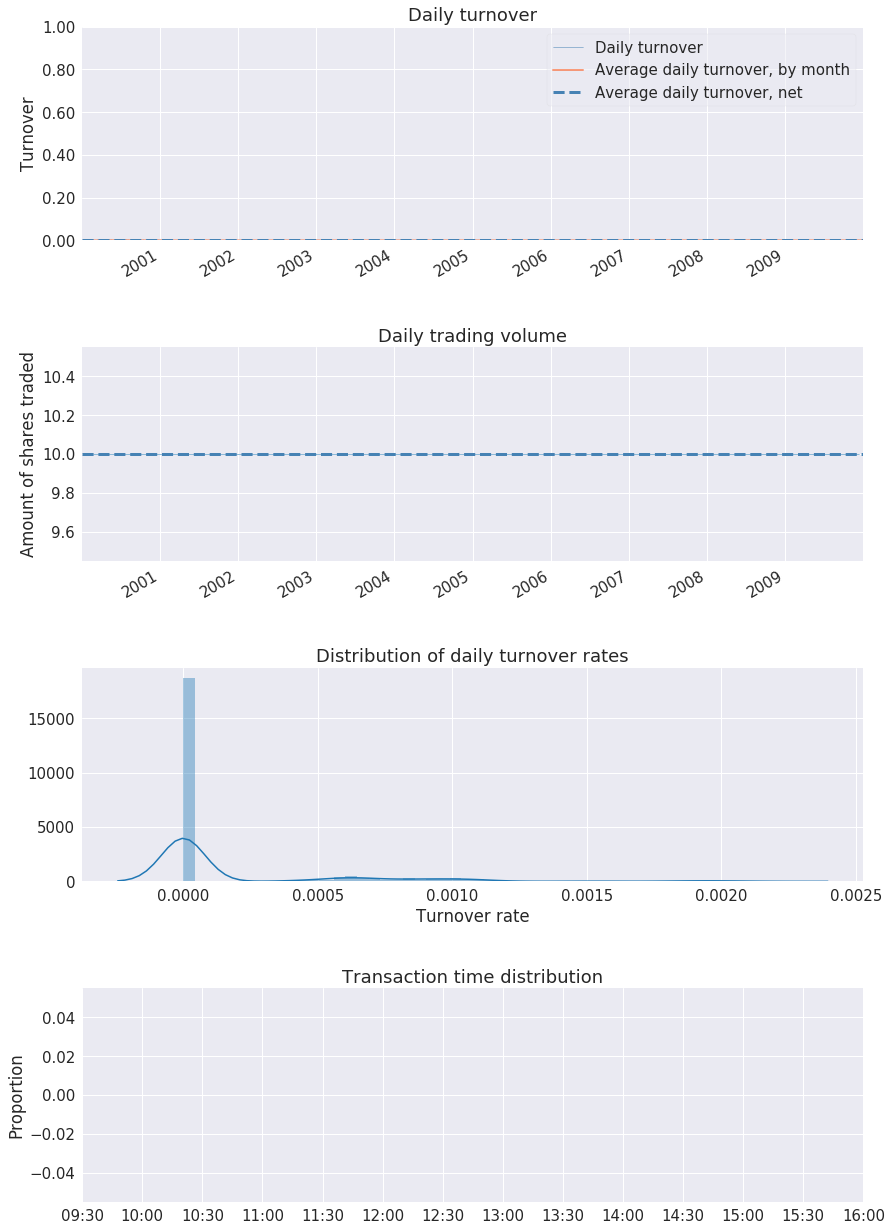

/usr/local/lib/python3.6/site-packages/pyfolio/round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/usr/local/lib/python3.6/site-packages/pyfolio/round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
/usr/local/lib/python3.6/site-packages/pyfolio/round_trips.py:379: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  round_trips.groupby('symbol')['returns'].agg(RETURN_STATS).T


Summary stats,All trades,Long trades
Total number of round_trips,245.00,245.00
Percent profitable,0.31,0.31
Winning round_trips,77.00,77.00
Losing round_trips,168.00,168.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$-370.50,$-370.50
Gross profit,$570.30,$570.30
Gross loss,$-940.80,$-940.80
Profit factor,$0.61,$0.61
Avg. trade net profit,$-1.51,$-1.51
Avg. winning trade,$7.41,$7.41
Avg. losing trade,$-5.60,$-5.60
Ratio Avg. Win:Avg. Loss,$1.32,$1.32
Largest winning trade,$104.10,$104.10
Largest losing trade,$-40.00,$-40.00


Duration stats,All trades,Long trades
Avg duration,7 days 13:36:58.779591,7 days 13:36:58.779591
Median duration,6 days 00:00:00,6 days 00:00:00
Longest duration,31 days 00:00:00,31 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,-0.00%,-0.00%
Avg returns winning,nan%,nan%
Avg returns losing,-0.00%,-0.00%
Median returns all round_trips,-0.00%,-0.00%
Median returns winning,nan%,nan%
Median returns losing,-0.00%,-0.00%
Largest winning trade,-0.00%,-0.00%
Largest losing trade,-0.00%,-0.00%


Symbol stats,ORCL
Avg returns all round_trips,-0.00%
Avg returns winning,nan%
Avg returns losing,-0.00%
Median returns all round_trips,-0.00%
Median returns winning,nan%
Median returns losing,-0.00%
Largest winning trade,-0.00%
Largest losing trade,-0.00%


Profitability (PnL / PnL total) per name,
symbol,
ORCL,100.00%


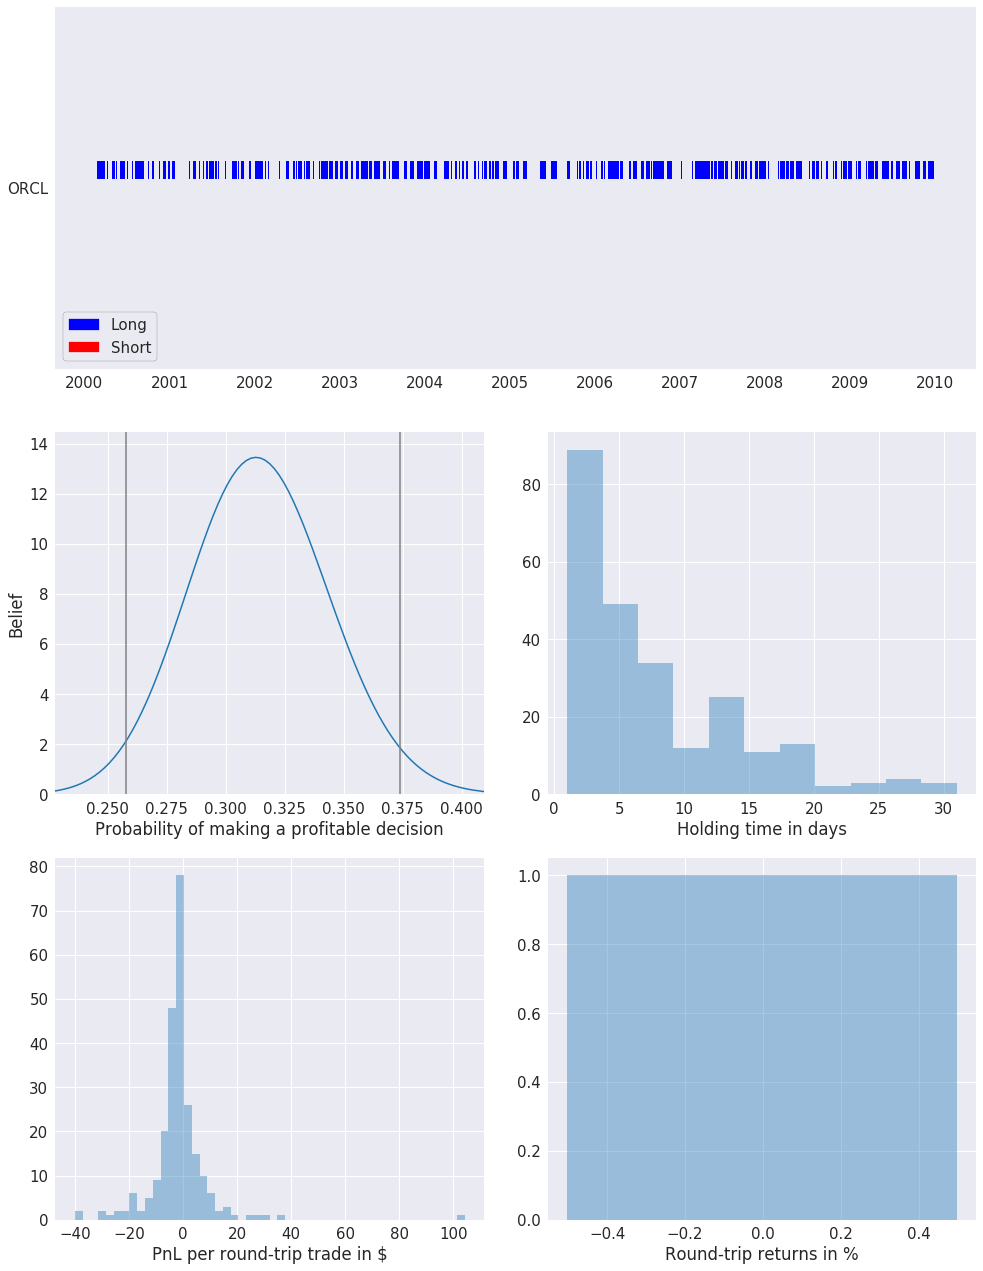

In [5]:
import pyfolio as pf
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    round_trips=True)